# Imports

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import xgboost as xgb
import warnings
warnings.simplefilter("ignore", UserWarning)
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Read the dataframe

In [3]:
file_path = r"C:\Users\karth\Downloads\operational_demand.csv"
df = pd.read_csv(file_path)

# Data Cleaning & Manipulation

In [4]:
df = df.drop(['awbiMetadataKeyHash', 'awbiMetadataChangeHash','awbiMetadataCreateDateTime',
                                'awbiMetadataLoadYear','awbiMetadataLoadMonth','awbiMetadataLoadDay',
                                'awbiMetadataLoadHour','awbiMetadataLoadDateTime'], axis=1)
df = df.reset_index(drop=True)

In [5]:
unique_value = df['operationalDemandWorkCentreGroup'].nunique()
print("Unique values in operationalDemandWorkCentreGroup: ", unique_value)

value_counts = df['operationalDemandWorkCentreGroup'].value_counts()
print("Value counts in operationalDemandWorkCentreGroup: ", value_counts)

Unique values in operationalDemandWorkCentreGroup:  1
Value counts in operationalDemandWorkCentreGroup:  operationalDemandWorkCentreGroup
493    6035
Name: count, dtype: int64


In [6]:
df.dtypes

operationalDemandDate                  object
operationalDemandOrderTypeGroup        object
operationalDemandProcess               object
operationalDemandWorkCentreGroup        int64
operationalDemandOpHoursCount           int64
operationalDemandOpHoursSum           float64
operationalDemandDateSid                int64
operationalDemandDateWeekBeginDate     object
operationalDemandSumZeroedRe          float64
operationalDemandOpTravelHours        float64
dtype: object

In [7]:
# Changing the operationalDemandDate column to a date time format allowing us to grab features from the date when required
df['operationalDemandDate'] = pd.to_datetime(df['operationalDemandDate'])

#Changing the columns below to a string/flot data type respecriveely to allow for data manipulation
df['operationalDemandWorkCentreGroup'] = df['operationalDemandWorkCentreGroup'].astype(str)
df['operationalDemandDateSid'] = df['operationalDemandDateSid'].astype(str)
df['operationalDemandOpTravelHours'] = df['operationalDemandOpTravelHours'].astype(float)

In [8]:
#Sorting the dates in an ascending order
df = df.sort_values(by=['operationalDemandDateWeekBeginDate','operationalDemandDate'], ascending= True)

In [9]:
# Making use of the dt.year/month etc repectively to create a new column in the dataset which stores only the year/month of the operationalDemandDate
df['OperationalDemandYear'] = df['operationalDemandDate'].dt.year
df['OperationalDemandMonth'] = df['operationalDemandDate'].dt.month
df['OperationalDemandDayofweek'] = df['operationalDemandDate'].dt.day_of_week
df['OperationalDemandQuarter'] = df['operationalDemandDate'].dt.quarter
df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
1158,2019-04-01,PLANNED,COLLECTION,493,140,83.700000,20190401,2019-04-01T00:00:00.000+0000,47.266667,54.224462,2019,4,0,2
4735,2019-04-01,PLANNED,TREATMENT,493,30,80.800000,20190401,2019-04-01T00:00:00.000+0000,47.666667,13.086870,2019,4,0,2
5039,2019-04-01,REACTIVE,MAINTENANCE,493,39,87.066667,20190401,2019-04-01T00:00:00.000+0000,59.500000,21.249216,2019,4,0,2
2338,2019-04-02,PLANNED,COLLECTION,493,1,0.500000,20190402,2019-04-01T00:00:00.000+0000,0.416667,0.238611,2019,4,1,2
3217,2019-04-02,REACTIVE,COLLECTION,493,20,38.233333,20190402,2019-04-01T00:00:00.000+0000,26.333333,8.394569,2019,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400,2024-01-29,PLANNED,COLLECTION,493,1,2.000000,20240129,2024-01-29T00:00:00.000+0000,0.000000,0.587613,2024,1,0,1
6028,2024-01-29,PLANNED,MAINTENANCE,493,129,118.083333,20240129,2024-01-29T00:00:00.000+0000,0.000000,67.171177,2024,1,0,1
254,2024-02-01,PLANNED,COLLECTION,493,120,86.883333,20240201,2024-01-29T00:00:00.000+0000,0.000000,70.513571,2024,2,3,1
5305,2024-02-01,PLANNED,MAINTENANCE,493,11,11.000000,20240201,2024-01-29T00:00:00.000+0000,0.000000,5.727775,2024,2,3,1


- **For OperationalDemandDayofweek**
- Monday = 0
- Tuesday = 1
- Wednesday = 2
- Thursday = 3
- Friday = 4
- Saturday = 5
- Sunday = 6

In [10]:
#Looking at the minimum date from when the forecasting data starts
print("The minimum date from when the forecasting data starts is: ", df['operationalDemandDate'].min())

#Looking at the minimum date from when the forecasting data ends
print("The maximum date from when the forecasting data ends is: ", df['operationalDemandDate'].max())

The minimum date from when the forecasting data starts is:  2019-04-01 00:00:00
The maximum date from when the forecasting data ends is:  2024-02-04 00:00:00


# Handling the outliers

In [11]:
#USing standard anomaly detection of q1/q3 +- 1.5 * IQR to identify outliers and improve the predictability of models

#Upper and Lower Quartiles for the flow data to identify IQR
q1_hours = df['operationalDemandOpHoursSum'].quantile(0.25)
q3_hours = df['operationalDemandOpHoursSum'].quantile(0.75)

#IQR and Upper and lower bounds to catch outliers 
iqr_hours = q3_hours - q1_hours
lower_bound_hours = q1_hours - 1.5 * iqr_hours
upper_bound_hours = q3_hours + 1.5 * iqr_hours


#Filtered Data frame to apply boundaries to values for each site and for the respective feature and response variables
df = df[
    (df['operationalDemandOpHoursSum'] >= lower_bound_hours) & (df['operationalDemandOpHoursSum'] <= upper_bound_hours)]

# Differntiating Weekday/Weekened

In [12]:
# Filtering a weekday df to only contain days from mon - fri
weekday_df = df[df['OperationalDemandDayofweek'].isin([0, 1, 2, 3, 4])]
weekday_df['OperationalDemandDayofweek'].unique()

array([0, 1, 2, 3, 4])

# Weekened Manipulation 

In [13]:
# Weeknd data set to only include sat - sun
weekend_df = df[df['OperationalDemandDayofweek'].isin([5, 6])]
weekend_df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
1812,2019-04-06,REACTIVE,?,493,1,0.416667,20190406,2019-04-01T00:00:00.000+0000,1.416667,0.596775,2019,4,5,2
4362,2019-04-06,REACTIVE,TREATMENT,493,9,10.333333,20190406,2019-04-01T00:00:00.000+0000,4.916667,2.705398,2019,4,5,2
1299,2019-04-07,REACTIVE,?,493,5,5.166667,20190407,2019-04-01T00:00:00.000+0000,6.666667,2.983873,2019,4,6,2
2297,2019-04-07,PLANNED,MAINTENANCE,493,2,5.533333,20190407,2019-04-01T00:00:00.000+0000,2.000000,2.146389,2019,4,6,2
3402,2019-04-07,REACTIVE,COLLECTION,493,15,32.516667,20190407,2019-04-01T00:00:00.000+0000,16.500000,7.100452,2019,4,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,2023-12-24,PLANNED,TREATMENT,493,18,9.000000,20231224,2023-12-18T00:00:00.000+0000,0.000000,17.457164,2023,12,6,4
625,2024-01-06,PLANNED,COLLECTION,493,1,1.000000,20240106,2024-01-01T00:00:00.000+0000,0.000000,0.587613,2024,1,5,1
5765,2024-01-14,PLANNED,COLLECTION,493,2,1.000000,20240114,2024-01-08T00:00:00.000+0000,0.000000,1.175226,2024,1,6,1
4363,2024-01-28,PLANNED,COLLECTION,493,1,4.000000,20240128,2024-01-22T00:00:00.000+0000,0.000000,0.587613,2024,1,6,1


In [14]:
# Weekend groupby in which we get a sum of hours for the weekend
weekend_groupby = weekend_df.groupby('operationalDemandDateWeekBeginDate')['operationalDemandOpHoursSum'].sum().reset_index()
weekend_groupby

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum
0,2019-04-01T00:00:00.000+0000,90.816667
1,2019-04-08T00:00:00.000+0000,79.333333
2,2019-04-15T00:00:00.000+0000,113.766667
3,2019-04-22T00:00:00.000+0000,38.583333
4,2019-04-29T00:00:00.000+0000,57.300000
...,...,...
245,2023-12-18T00:00:00.000+0000,11.250000
246,2024-01-01T00:00:00.000+0000,1.000000
247,2024-01-08T00:00:00.000+0000,1.000000
248,2024-01-22T00:00:00.000+0000,4.000000


In [16]:
# Shift function to create date time features in which we can utlise previous weeks data as covariates to predict workload 
def shift_function(df,new_column_name,shift):
  df[new_column_name] = df['operationalDemandOpHoursSum'].shift(shift)
  
# Shift function to create previous week's features for the weekend 
shift_1_weekend = shift_function(weekend_groupby, 'prev_week_1', 1)
shift_2_weekend = shift_function(weekend_groupby, 'prev_week_2', 2)
shift_3_weekend = shift_function(weekend_groupby, 'prev_week_3', 3)
shift_4_weekend = shift_function(weekend_groupby, 'prev_week_4', 4)

In [17]:
# dropping na's as a result of the shift function
weekend_groupby = weekend_groupby.dropna(axis=0)

In [18]:
# extracting date time featuresfor covariates within the prediction

weekend_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(weekend_groupby['operationalDemandDateWeekBeginDate'])
weekend_groupby['OperationalDemandYear'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.year
weekend_groupby['OperationalDemandMonth'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.month
weekend_groupby['OperationalDemandWeek'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.isocalendar().week

C:\Users\karth\AppData\Local\Temp\ipykernel_16284\2529061735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(weekend_groupby['operationalDemandDateWeekBeginDate'])
C:\Users\karth\AppData\Local\Temp\ipykernel_16284\2529061735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_groupby['OperationalDemandYear'] = weekend_groupby['operationalDemandDateWeekBeginDate'].dt.year
C:\Users\karth\AppData\Local\Temp\ipykernel_16284\25290

# Weekday Manipulation

In [19]:
# grouping by the week and the operational demand sum to get a sum for the week
week_groupby = weekday_df.groupby('operationalDemandDateWeekBeginDate')['operationalDemandOpHoursSum'].sum().reset_index()

# Alligning the dates for both week and weekend to ensure both df's have the same date time frame
week_groupby = week_groupby.drop(index=236, axis=1)
week_groupby

,operationalDemandDateWeekBeginDate,operationalDemandOpHoursSum
0,2019-04-01T00:00:00.000+0000,680.300000
1,2019-04-08T00:00:00.000+0000,501.683333
2,2019-04-15T00:00:00.000+0000,583.566667
3,2019-04-22T00:00:00.000+0000,346.100000
4,2019-04-29T00:00:00.000+0000,648.450000
...,...,...
247,2024-01-01T00:00:00.000+0000,2.000000
248,2024-01-08T00:00:00.000+0000,0.500000
249,2024-01-15T00:00:00.000+0000,87.250000
250,2024-01-22T00:00:00.000+0000,5.633333


# Shift Function for Week

In [20]:


# previous week's data ranging from week 1 - 4
shift_1_week = shift_function(week_groupby, 'prev_week_1', 1)
shift_2_week = shift_function(week_groupby, 'prev_week_2', 2)
shift_3_week = shift_function(week_groupby, 'prev_week_3', 3)
shift_4_week = shift_function(week_groupby, 'prev_week_4', 4)

In [21]:
# The shift function creates na within the df in which need to be dropped
week_groupby = week_groupby.dropna(axis=0)

In [22]:
week_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(week_groupby['operationalDemandDateWeekBeginDate'])
week_groupby['OperationalDemandYear'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.year
week_groupby['OperationalDemandMonth'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.month
week_groupby['OperationalDemandWeek'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.isocalendar().week

C:\Users\karth\AppData\Local\Temp\ipykernel_16284\1355344860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_groupby['operationalDemandDateWeekBeginDate'] = pd.to_datetime(week_groupby['operationalDemandDateWeekBeginDate'])
C:\Users\karth\AppData\Local\Temp\ipykernel_16284\1355344860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_groupby['OperationalDemandYear'] = week_groupby['operationalDemandDateWeekBeginDate'].dt.year
C:\Users\karth\AppData\Local\Temp\ipykernel_16284\1355344860.py:3: 

# EDA

[Text(0.5, 1.0, 'Operational demand time series plot')]

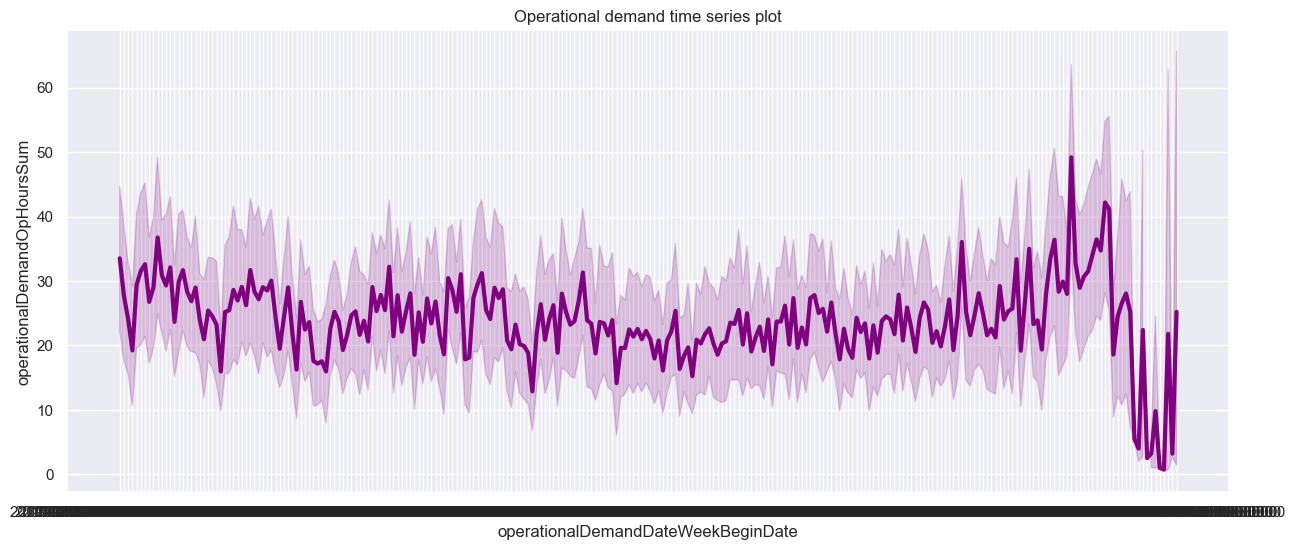

In [23]:
#time series plot for operational hours from start to end

#Week commencing on the x-axis
x = df['operationalDemandDateWeekBeginDate']

#total hours for the week
y = df['operationalDemandOpHoursSum']

#Seaborn timeseries plot

#Seaborn timeseries plot
sns.set(rc={"figure.figsize":(15, 6)})
sns.lineplot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', data=df, linewidth=3, color='purple',
             linestyle='solid').set(title='Operational demand time series plot')

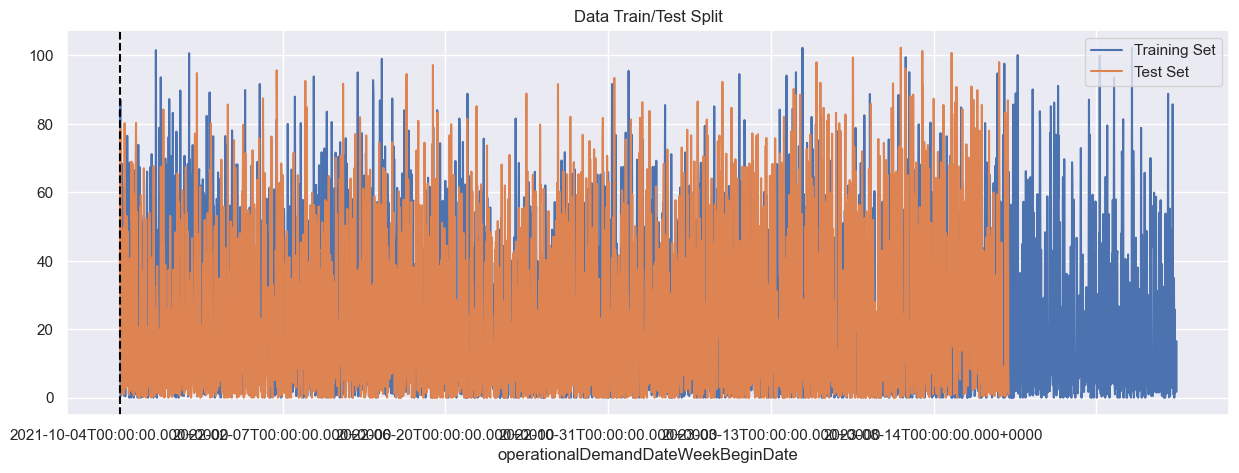

In [24]:
#Filtered data set of train and test split everything before 1st October 2021 trained & everything after tested
train = df.loc[df['operationalDemandDateWeekBeginDate'] < '2021-10-01']
test = df.loc[df['operationalDemandDateWeekBeginDate'] >= '2021-10-01']

#Creation of a new filtered dataframe for train and test splits creates and index for the new df, if not accounted for the plot will include the index 
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

#Creation of plots and subplots to plot train and test sets on different axis 
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(x='operationalDemandDateWeekBeginDate', y='operationalDemandOpHoursSum', ax=ax, label='Test Set')
ax.axvline('2021-10-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [25]:
#Looking at the minimum date from when the forecasting data starts
train.min()

operationalDemandDate                          2019-04-01 00:00:00
operationalDemandOrderTypeGroup                                  ?
operationalDemandProcess                                         ?
operationalDemandWorkCentreGroup                               493
operationalDemandOpHoursCount                                    1
operationalDemandOpHoursSum                                    0.0
operationalDemandDateSid                                  20190401
operationalDemandDateWeekBeginDate    2019-04-01T00:00:00.000+0000
operationalDemandSumZeroedRe                                   0.0
operationalDemandOpTravelHours                            0.000278
OperationalDemandYear                                         2019
OperationalDemandMonth                                           1
OperationalDemandDayofweek                                       0
OperationalDemandQuarter                                         1
dtype: object

# Time Series split for a month of data

In [40]:
#Applying time series eda to assess behaviour within a week on data
month1_df = df.loc[(df['operationalDemandDateWeekBeginDate'] >= '2023-04-01') & 
                              (df['operationalDemandDateWeekBeginDate'] < '2023-05-01') &
                              (df['operationalDemandDate'] >=  '2023-04-01') & 
                              (df['operationalDemandDate'] <= '2023-05-01')]

In [41]:
# Sorting the values in the df by the columns in ascending order 
month1_df = month1_df.sort_values(by=['operationalDemandDateWeekBeginDate', 'operationalDemandDate'], ascending=True)

In [42]:
month1_df

,operationalDemandDate,operationalDemandOrderTypeGroup,operationalDemandProcess,operationalDemandWorkCentreGroup,operationalDemandOpHoursCount,operationalDemandOpHoursSum,operationalDemandDateSid,operationalDemandDateWeekBeginDate,operationalDemandSumZeroedRe,operationalDemandOpTravelHours,OperationalDemandYear,OperationalDemandMonth,OperationalDemandDayofweek,OperationalDemandQuarter
411,2023-04-03,PLANNED,COLLECTION,493,4,0.200000,20230403,2023-04-03T00:00:00.000+0000,0.166667,2.350452,2023,4,0,2
507,2023-04-03,PLANNED,MAINTENANCE,493,44,88.530000,20230403,2023-04-03T00:00:00.000+0000,40.833333,20.340621,2023,4,0,2
1844,2023-04-03,REACTIVE,?,493,7,1.750000,20230403,2023-04-03T00:00:00.000+0000,1.083333,2.363769,2023,4,0,2
3483,2023-04-03,REACTIVE,TREATMENT,493,23,33.333333,20230403,2023-04-03T00:00:00.000+0000,13.000000,28.193479,2023,4,0,2
5938,2023-04-03,PLANNED,TREATMENT,493,32,52.716667,20230403,2023-04-03T00:00:00.000+0000,48.666667,18.802442,2023,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2023-04-28,REACTIVE,?,493,4,2.033333,20230428,2023-04-24T00:00:00.000+0000,4.333333,0.573444,2023,4,4,2
3403,2023-04-28,PLANNED,COLLECTION,493,4,1.866667,20230428,2023-04-24T00:00:00.000+0000,5.200000,1.178282,2023,4,4,2
335,2023-04-29,PLANNED,TREATMENT,493,16,22.846667,20230429,2023-04-24T00:00:00.000+0000,15.500000,11.655332,2023,4,5,2
5324,2023-04-29,REACTIVE,TREATMENT,493,7,15.450000,20230429,2023-04-24T00:00:00.000+0000,4.000000,3.897425,2023,4,5,2


In [43]:
import plotly.express as px

#Line graphs to assess typical trend of operational hours within a week
fig = px.line(month1_df, x='operationalDemandDate', y='operationalDemandOpHoursSum')

#Appropiate axis labelling
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='operationalDemandOpHoursSum')

#title labelling
fig.update_layout(title='Time Series Plot for the January 2023')

fig.show()
